# Exploring customer segmentation and customer lifetime value for sales forecasting

**Background**

A UK-based company that supplies unique all-occasion gifts, such as themed dishware and trendy household items, takes pride in offering an unparalleled selection of carefully curated products designed to enhance every special moment. With over 1 million transactions realized between 2009 and 2011, this company provides products for wholesalers, retail stores, or resellers. This means it sells to sales channel partners and stores that are looking for unique gift ideas and products for their customers. As a product supplier for wholesale stores, the company deals with cancellations and bulk orders. Due to the nature of the gift-giving product category, the volume of business is high during peak holiday seasons, which in the UK occur from October to December.


The challenge is to better understand the customer data available and historical sales, to identify an opportunity to build targeted segments to market and to forecast sales.


Another key factor to keep in mind is that the analysis also considers cancellations and returns, so the segmentation approach should identify customer groups who are qualified customers who generally don’t show indicators of returning or canceling their orders. A key goal in retail is to ensure profitable sales that minimize returns and cancellations, which impacts the profitability of the organization.

**Objectives**

- Understand the data of the challenge and its features.
- Perform an exploratory data analysis to identify patterns and insights that help solve the challenge.
- Prepare the data that will be necessary to solve the challenge.
- Establish a customer segmentation technique and describe the results.
- Define the strategy, implement the forecast model for each customer segment, and describe the results.
- Present the results and main insights found in the execution of the challenge.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")


In [2]:
xls = pd.ExcelFile('online_retail_II.xlsx')
dat1 = pd.read_excel(xls, "Year 2009-2010")
dat2 = pd.read_excel(xls, "Year 2010-2011")
dat = pd.concat([dat1, dat2], ignore_index=True)
dat.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 1. The Raw Data

| Data Element | Type     | Description                                                                                                                                               |
|--------------|----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Invoice      | object   | Invoice number. A 6-digit integral number is uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. |
| StockCode    | object   | Product (item) code. A unique 5-digit integral number is assigned to each distinct product.                                                               |
| Description  | object   | Product (item) name. |
| Quantity     | int64    | The quantities of each product (item) per transaction. |
| InvoiceDate  | datetime | Invoice date and time. The day and time when a transaction was generated. |
| Price        | float64  | Unit price.  Product price per unit in pounds (£). |
| Customer ID  | int64    | Customer number.  A unique 5-digit integral number is assigned to each customer. |
| Country      | object   | Country name. The name of the country where a customer resides. |


# 2. Cleaning

In [7]:
# Cancellations/Returns
dat['Cancelled'] = False
dat.loc[dat.Invoice.astype(str).str.startswith('C'), 'Cancelled'] = True

# Nans
for col in dat.columns:
    print(f'there are {sum(dat[col].isna())} Nans in the {col} column')

# Start simple. just drop them    
df = dat.dropna() 
print(f' {dat.size - df.size} rows were dropped due to nans ({((dat.size - df.size)/ dat.size) * 100} %).') 

# Distribute the year, month, day, and time components into separate columns
df['Year'] = df.InvoiceDate.dt.year
df['Month'] = df.InvoiceDate.dt.month
df['Week'] = df.InvoiceDate.dt.isocalendar().week
df['Day'] = df.InvoiceDate.dt.day
df['Time'] = df.InvoiceDate.dt.time

df['Total'] = df.Quantity * df.Price
df = df[df.Cancelled == False].reset_index()
# Dropping test transactions
df = df[~df.StockCode.astype(str).str.contains('TEST')].reset_index(drop=True)


there are 0 Nans in the Invoice column
there are 0 Nans in the StockCode column
there are 4382 Nans in the Description column
there are 0 Nans in the Quantity column
there are 0 Nans in the InvoiceDate column
there are 0 Nans in the Price column
there are 243007 Nans in the Customer ID column
there are 0 Nans in the Country column
there are 0 Nans in the Cancelled column
 2187063 rows were dropped due to nans (22.766872999172733 %).


## Outliers

In [8]:
# Calculate total spending per customer
customer_spending = df.groupby('Customer ID')['Total'].sum()
# Calculate purchase frequency per customer
customer_purchase_count = df.groupby('Customer ID')['Invoice'].nunique()

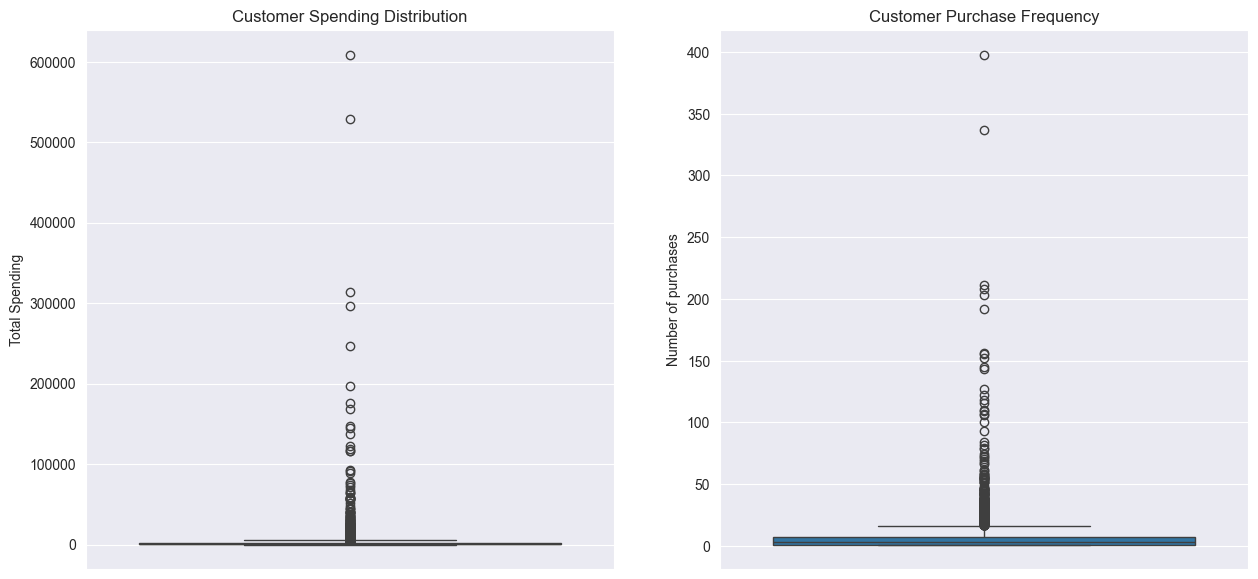

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15, 7))
# Example: Box plot of customer spending
sns.boxplot(y=customer_spending, ax=ax[0])
ax[0].set_title('Customer Spending Distribution')
ax[0].set_ylabel('Total Spending')

# Example: Box plot of customer purchasing frequency
sns.boxplot(y=customer_purchase_count, ax=ax[1])
ax[1].set_title('Customer Purchase Frequency')
ax[1].set_ylabel('Number of purchases')
plt.show()

<Axes: ylabel='Total'>

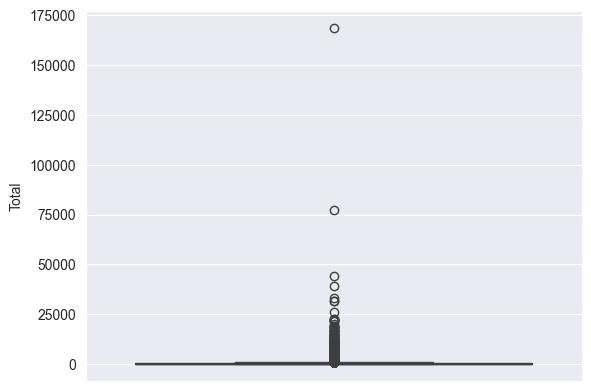

In [10]:
invoice_totals = df.groupby('Invoice').Total.sum()#.max()
invoice_totals.loc[invoice_totals == invoice_totals.max()]
sns.boxplot(y=invoice_totals)

In [10]:
invoice_totals.loc[invoice_totals == invoice_totals.max()]


Invoice
581483    168469.6
Name: Total, dtype: float64

In [11]:
df.loc[df.Invoice == 581483]

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cancelled,Year,Month,Week,Day,Time,Total
805134,1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False,2011,12,49,9,09:15:00,168469.6


There are clearly some big spenders that may not be useful for prediction because they're outliers

In [11]:
# Define a function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers in customer spending
invoice_outliers  = detect_outliers_iqr(invoice_totals)
df = df.loc[~df['Invoice'].isin(invoice_totals.index[invoice_outliers].tolist())]
#df = df[~]
print(f'  {sum(invoice_outliers)} Invoices were dropped because they were outside the interquartile range in spending.')



  3972 Invoices were dropped because they were outside the interquartile range in spending.


# 3. Exploratory Data Analysis


## Historical Sales by Time

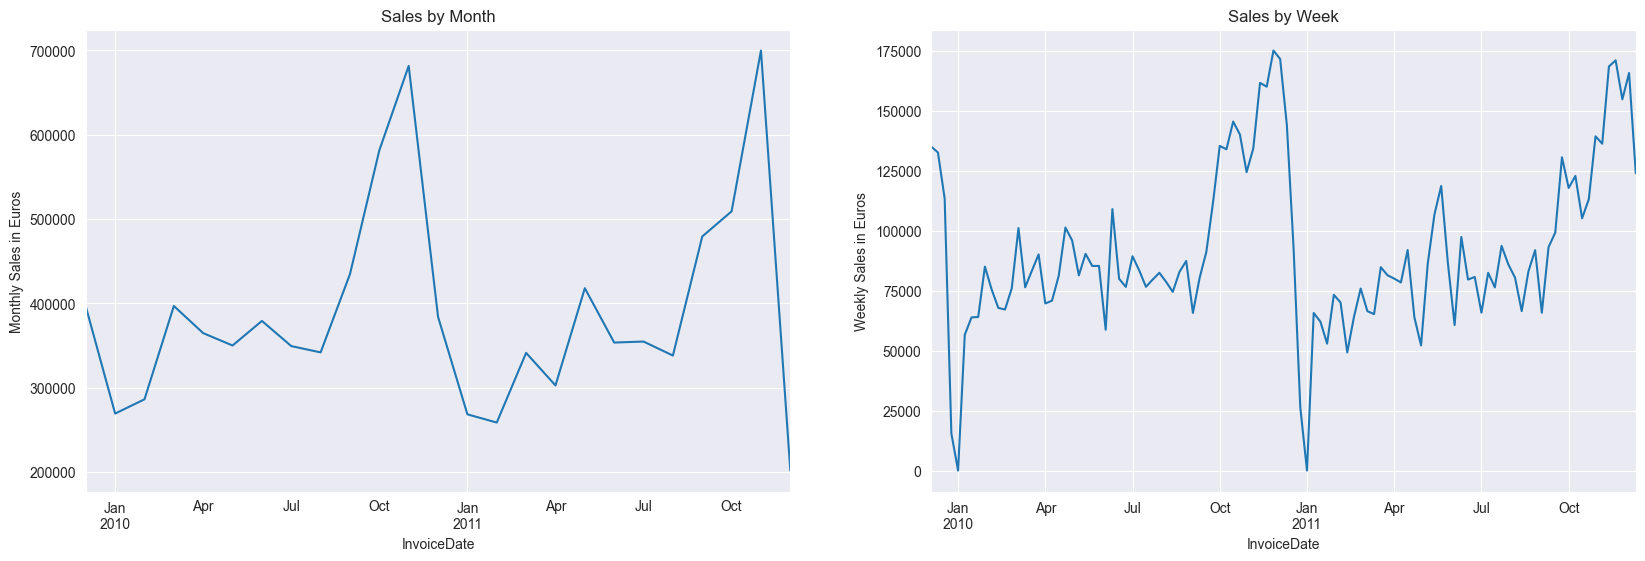

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
df.set_index('InvoiceDate').Total.resample('M').sum().plot(ax=ax[0], title='Sales by Month');
df.set_index('InvoiceDate').Total.resample('W').sum().plot(ax=ax[1], title='Sales by Week');
ax[0].set_ylabel('Monthly Sales in Euros');
ax[1].set_ylabel('Weekly Sales in Euros');


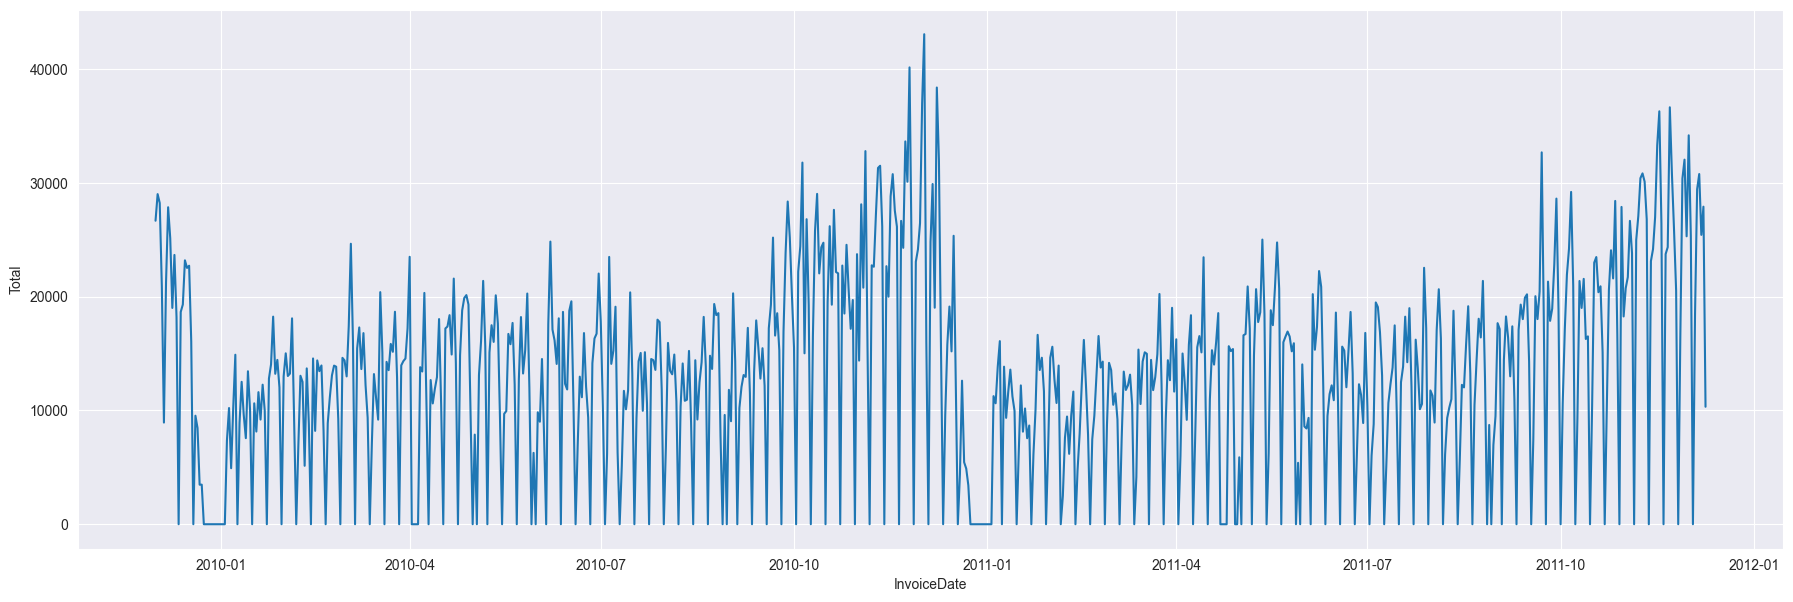

In [13]:
f, ax = plt.subplots(figsize=(22, 7))
df_agg = df.groupby([ pd.Grouper(key='InvoiceDate', freq='D')])['Total'].sum().reset_index()
sns.lineplot(data=df_agg, x='InvoiceDate', y='Total', ax=ax );

This tells use a couple things:
The shop is closed from December 24th to January 3rd each year.
The shop is closed on Sundays. 

During each of these times, sales = 0
 

##  Monthly Historical Sales by Country


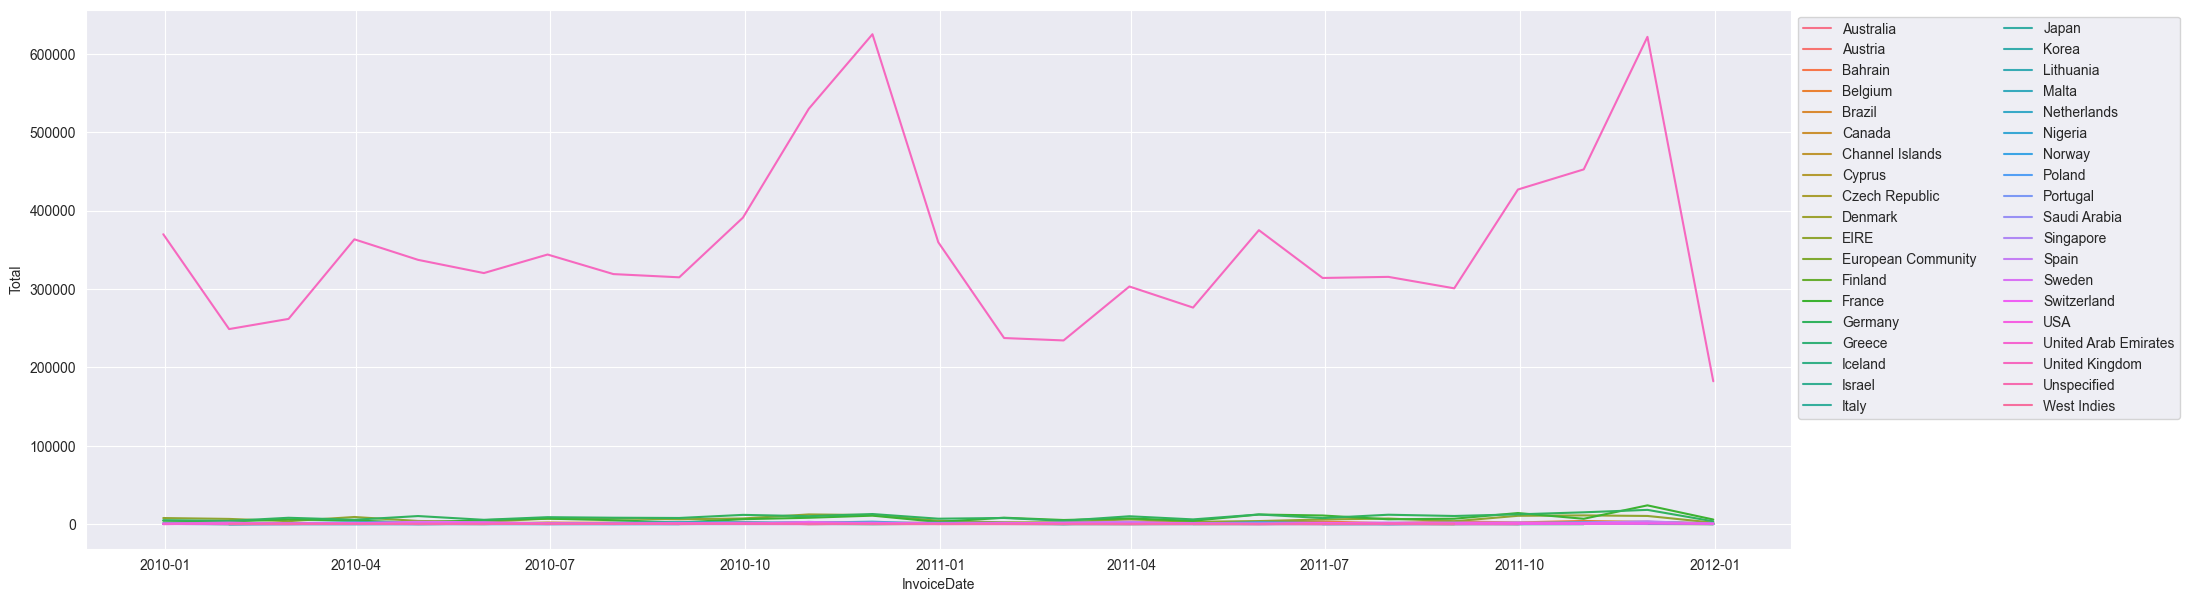

In [14]:
f, ax = plt.subplots(figsize=(22, 7))
df_agg = df.groupby(['Country', pd.Grouper(key='InvoiceDate', freq='M')])['Total'].sum().reset_index()
sns.lineplot(data=df_agg, x='InvoiceDate', y='Total', hue='Country', ax=ax );
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2);

Most Sales are in the UK so Country may not be the most useful variable for segmentation. Or perhaps All non-UK customer may fall into their own segment. 

# 4. Recency, Frquency, & Monetary Value 

In [15]:
# Select features for segmentation
# Here, we'll use 'Recency', 'Frequency', and 'Monetary' for an RFM-based segmentation
# You can define these metrics based on your specific business context
#df.reset_index(inplace=True)
rfm_data = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (pd.Timestamp.now() - x.max()).days,  # Recency
    'Invoice': 'count',  # Frequency
    'Total': 'sum'  # Monetary
}).reset_index()
rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']


In [18]:
rfm_data

,Customer ID,Recency,Frequency,Monetary
0,12346.0,4865,24,169.36
1,12347.0,4338,144,2915.42
2,12348.0,4411,51,2019.40
3,12349.0,4906,1,200.00
4,12350.0,4646,17,334.40
...,...,...,...,...
5777,18283.0,4339,986,2736.65
5778,18284.0,4767,28,461.68
5779,18285.0,4996,12,427.00
5780,18286.0,4812,67,1296.43


In [16]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])


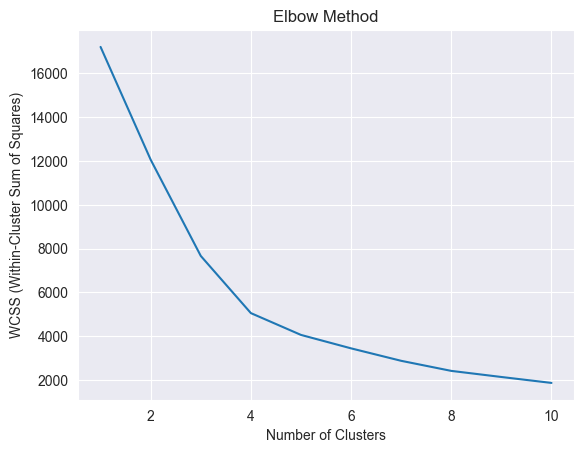

In [17]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to identify the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


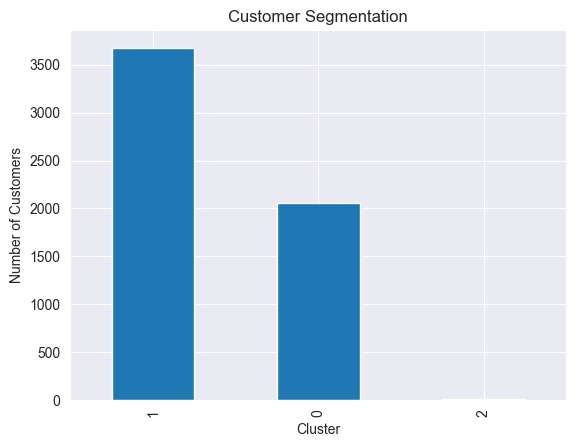

In [18]:
# Based on the Elbow Method plot, choose the optimal number of clusters
num_clusters = 3  # Adjust this based on your analysis

# Apply K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters
rfm_data['Cluster'].value_counts().plot(kind='bar')
plt.title('Customer Segmentation')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Now, rfm_data contains the customer segments (clusters)


In [21]:
rfm_data.loc[rfm_data.Cluster == 2].describe()

,Customer ID,Recency,Frequency,Monetary,Cluster
count,6.000000,6.00000,6.000000,6.000000,6.0
mean,15544.500000,4400.00000,5918.500000,62000.248333,2.0
std,1987.273585,150.91322,3358.496137,32606.176209,0.0
min,12748.000000,4336.00000,2657.000000,30861.060000,2.0
25%,14682.250000,4336.25000,3342.500000,47116.745000,2.0
50%,15111.000000,4338.50000,5925.500000,53905.955000,2.0
75%,17208.500000,4342.25000,6551.000000,61327.565000,2.0
max,17850.000000,4708.00000,11762.000000,124673.410000,2.0


In [22]:
rfm_data.loc[rfm_data.Cluster == 1].describe()


,Customer ID,Recency,Frequency,Monetary,Cluster
count,3675.000000,3675.000000,3675.000000,3675.000000,3675.0
mean,15321.917007,4401.117007,143.985850,2240.125162,1.0
std,1709.856836,66.164025,206.806916,3217.508104,0.0
min,12347.000000,4336.000000,1.000000,0.000000,1.0
25%,13848.500000,4352.000000,32.000000,551.055000,1.0
50%,15325.000000,4376.000000,75.000000,1226.710000,1.0
75%,16804.500000,4430.000000,173.500000,2677.960000,1.0
max,18287.000000,4833.000000,2528.000000,49916.730000,1.0


In [23]:
rfm_data.loc[rfm_data.Cluster == 0].describe()


,Customer ID,Recency,Frequency,Monetary,Cluster
count,2053.000000,2053.000000,2053.000000,2053.000000,2053.0
mean,15365.835363,4792.593765,38.092060,552.802393,0.0
std,1709.365895,131.264634,48.434275,593.787211,0.0
min,12346.000000,4568.000000,1.000000,2.950000,0.0
25%,13896.000000,4710.000000,11.000000,186.660000,0.0
50%,15369.000000,4764.000000,23.000000,359.400000,0.0
75%,16857.000000,4891.000000,47.000000,697.060000,0.0
max,18286.000000,5074.000000,620.000000,6043.310000,0.0


100%|██████████| 5734/5734 [00:13<00:00, 421.00it/s]


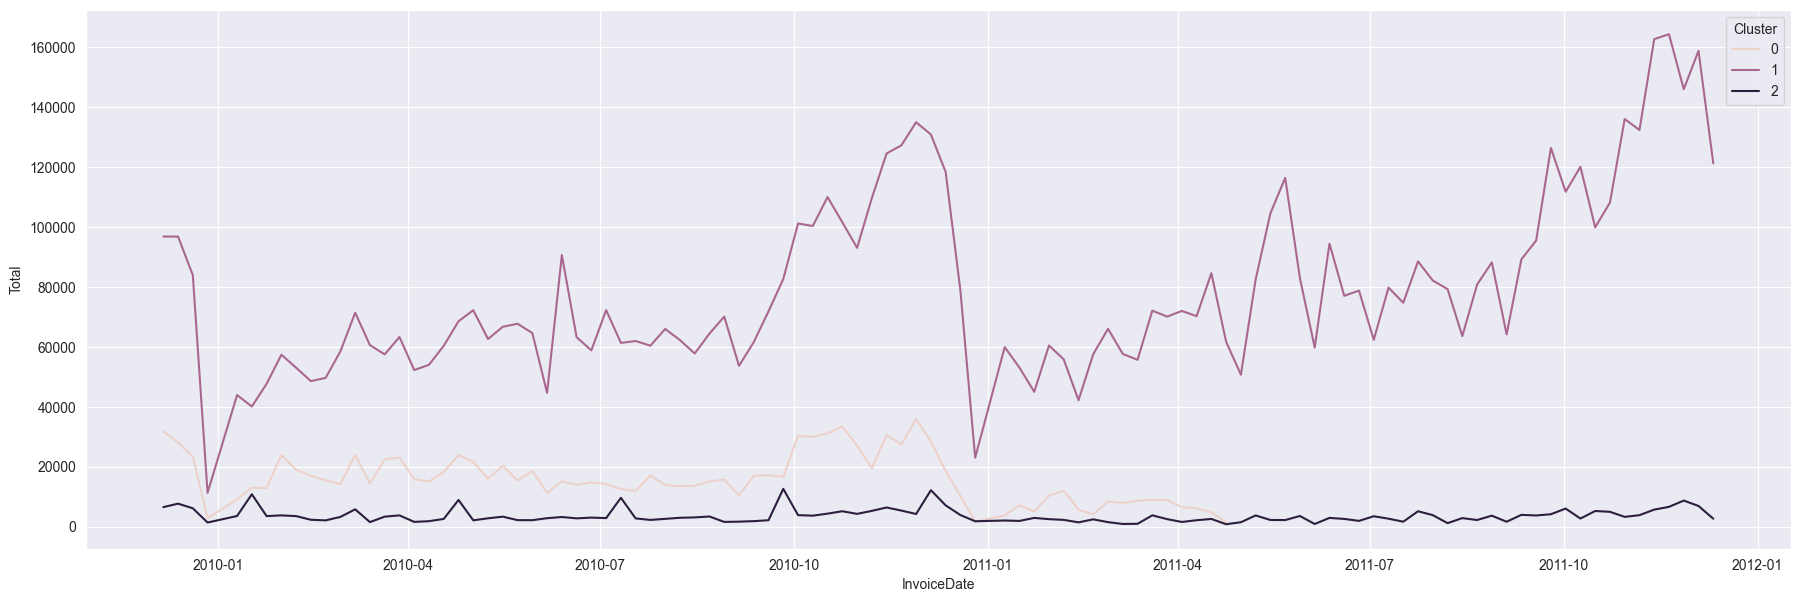

In [24]:
df['Cluster'] = None
for customer in tqdm(df['Customer ID'].unique()):
    c = rfm_data.loc[rfm_data['Customer ID'] == customer].Cluster.values[0]
    df.loc[df['Customer ID'] == customer, 'Cluster'] = c    

f, ax = plt.subplots(figsize=(22, 7))

df_agg2 = df.groupby(['Cluster', pd.Grouper(key='InvoiceDate', freq='W')])['Total'].sum().reset_index()
sns.lineplot(data=df_agg2, x='InvoiceDate', y='Total', hue='Cluster', ax=ax );
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2);
plt.show()

It looks like cluster 1 shows the cyclical pattern more than others. Suggesting we should weight them differently in our forecast model. 

# Forcast

In [39]:
# Group and aggregate data by a specific time frequency (e.g., daily sales)
df_agg = df.groupby(pd.Grouper(key='InvoiceDate', freq='D'))['Total'].sum()

# Check for stationarity using the Dickey-Fuller test
result = adfuller(df_agg)
print(f'First Pass ADF p value:{result[1]}')

df_agg1 = df_agg.diff().dropna()
result = adfuller(df_agg1)
print(f'First Pass ADF with first order differencs p value:{result[1]}')

df_agg2 = df_agg.diff().diff().dropna()
result = adfuller(df_agg2)
print(f'First Pass ADF with second order differencs p value:{result[1]}')

#if result[1] < 0.05:
    # Perform differencing if the data is not stationary
    #df_agg = df_agg.diff().dropna()

First Pass ADF p value:0.04574179608947945
First Pass ADF with first order differencs p value:4.3454845186019854e-11
First Pass ADF with first order differencs p value:6.106431880100768e-22


Looks like I don't need to difference

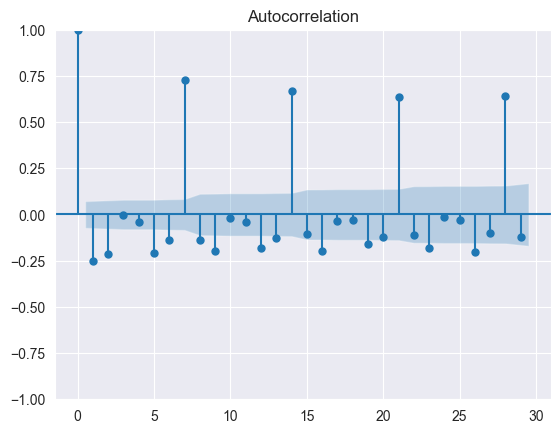

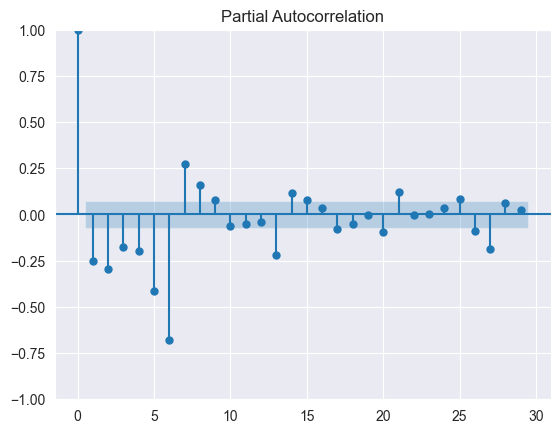

In [41]:
# Determine ARIMA orders (p, d, q) using ACF and PACF plots
plot_acf(df_agg.diff().dropna())
plot_pacf(df_agg.diff().dropna())
plt.show()

In [74]:
from statsmodels.tsa.arima.model import ARIMA

df_agg = df_agg.diff().dropna()
#Fit an ARIMA model
p = 6  # Order of AR
d = 0  # Order of differencing
q = 3  # Order of MA
# Split the data into training and testing sets
train_data = df_agg[:-30]  # Leave out the last 30 days for testing
test_data = df_agg[-30:]

# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Forecast future data points
forecast= model_fit.forecast(steps=30)

In [62]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  700
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -8931.395
Date:                Mon, 23 Oct 2023   AIC                          17878.790
Time:                        21:00:25   BIC                          17915.199
Sample:                    12-10-2009   HQIC                         17892.864
                         - 11-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1485.3424    162.012     -9.168      0.000   -1802.880   -1167.805
ar.L1         -2.9814      0.040    -75.207      0.000      -3.059      -2.904
ar.L2         -4.4992      0.094    -47.907      0.0

<Axes: xlabel='InvoiceDate'>

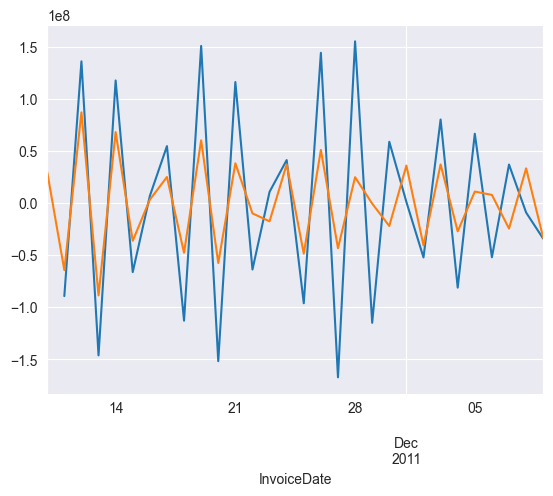

In [75]:
test_data.diff().dropna().plot()
forecast.plot()


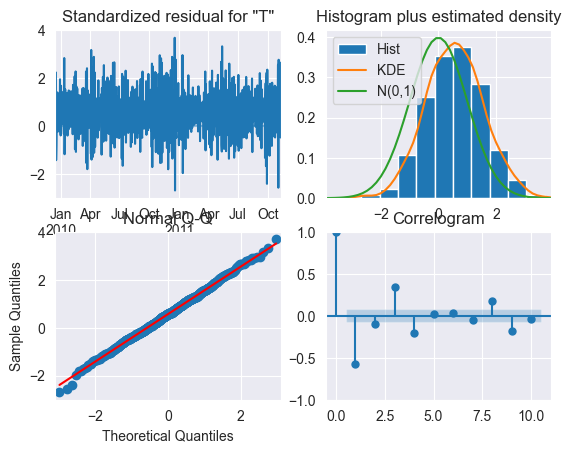

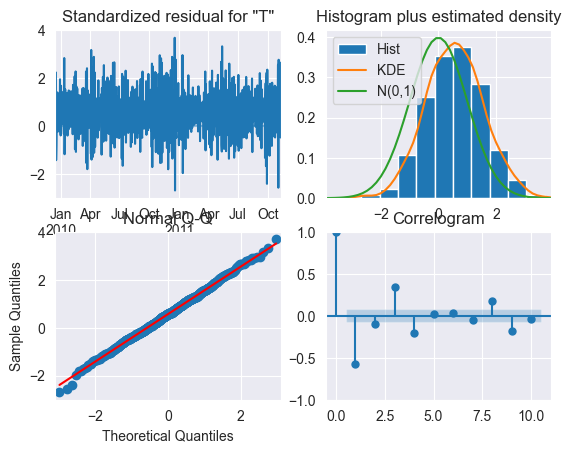

In [76]:
model_fit.plot_diagnostics()

# Random Random Forrest

In [14]:


for seg in range(3):    
    # Select a customer segment (e.g., segment 0)
    segment_data = df[df['Cluster'] == seg]
    
    # Train a Random Forest Regressor for the selected segment
    X_segment = segment_data[['InvoiceDate', 'Price']]
    y_segment = segment_data['Total']
    
    # Feature engineering (convert InvoiceDate to numeric features)
    X_segment['Year'] = X_segment['InvoiceDate'].dt.year
    X_segment['Month'] = X_segment['InvoiceDate'].dt.month
    X_segment['Day'] = X_segment['InvoiceDate'].dt.day
    X_segment['Hour'] = X_segment['InvoiceDate'].dt.hour
    
    X_segment = X_segment.drop(columns=['InvoiceDate'])
    
    # Split the segment data into training and testing sets
    X_train_segment, X_test_segment, y_train_segment, y_test_segment = train_test_split(X_segment, y_segment, test_size=0.2, random_state=42)
    
    # Train the model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_segment, y_train_segment)
    
    # Make predictions
    y_pred_segment = model.predict(X_test_segment)
    
    # Evaluate the model
    rmse_segment = np.sqrt(mean_squared_error(y_test_segment, y_pred_segment))
    print(f'Root Mean Squared Error for Segment {seg}: {rmse_segment}')



Root Mean Squared Error for Segment 0: 39.139797984555074
Root Mean Squared Error for Segment 1: 61.10862627587965
Root Mean Squared Error for Segment 2: 57.08403798388702
